# Steganography Detection using CNN in PyTorch
Dieses Notebook zielt darauf ab, ein Convolutional Neural Network (CNN) zu trainieren, um PNG-Bilder mit verstecktem Inhalt (z. B. JavaScript, PowerShell-Skripte und URLs) von normalen PNGs zu unterscheiden.
Dataset: 8,000 PNGs (512x512), die entweder „clean“ oder „kompromittiert“ sind (LSB-Steganographie).
python 3.11.9

# 1. Setup
Importiere die benötigten Bibliotheken und definiere die grundlegenden Parameter + Cuda einrichten

In [2]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.data import Subset
from PIL import Image
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 16
learning_rate = 0.001
num_epochs = 20
num_epochs1 = 5

# Device-Erkennung (GPU oder CPU) für cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


# 2. Datensatz vorbereiten
Lade die Bilder und erstelle eine PyTorch Dataset-Klasse für den Umgang mit PNG-Dateien.

In [2]:
class SteganalysisDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        # Initialize paths, labels, etc.
        self.data_dir = data_dir
        self.transform = transform
        # Load image paths and labels (implement this part based on your dataset structure)
        self.image_paths = []  # List of image file paths
        self.labels = []       # Corresponding labels (0 for clean, 1 for steg)

        for label, subdir in enumerate(['clean', 'stego']):
            path = os.path.join(data_dir, subdir)
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and label
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        # Load image using PIL or cv2
        # Apply transforms
        return image, label

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Reduce the dataset size
subset_size = 4000  # Use 2000 clean and 2000 steg images
indices = torch.randperm(len(SteganalysisDataset(data_dir='data/train', transform=transform)))[:subset_size]
train_subset = Subset(SteganalysisDataset(data_dir='data/train', transform=transform), indices)

# Create a DataLoader with reduced batch size
train_loader1 = DataLoader(train_subset, batch_size=16, shuffle=True)

# Dataset and DataLoader
train_dataset = SteganalysisDataset(data_dir='data/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = SteganalysisDataset(data_dir='data/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import os

paths = ["data/test/stego_b64", "data/test/clean", "data/test/stego", "data/test/stego_zip", "data/train/clean", "data/train/stego"]
numbers = []

for path in paths:  # 'paths' direkt durchlaufen
    x = 0
    if os.path.exists(path):  # Überprüfen, ob der Pfad existiert
        for img_name in os.listdir(path):  # Dateien im Pfad zählen
            x += 1
    else:
        print(f"Pfad nicht gefunden: {path}")
    numbers.append(x)

print(numbers)

[6000, 2000, 6000, 6000, 4000, 12000]


# 3. Modell definieren
Erstellen eines CNN-Modells zur Unterscheidung von „clean“ und „kompromittierten“ Bildern.

In [3]:
# Define your CNN architecture
class SteganalysisCNN(nn.Module):
    def __init__(self):
        super(SteganalysisCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Input channels: 3 (RGB), Output: 16
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Increase channels to 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Further downsample
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * (512 // 8) * (512 // 8), 512),  # Adjust for input image size (512x512)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),  # Binary classification (steganography or not)
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
    

model = SteganalysisCNN().to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 4. Training-Funktion

In [4]:
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    
    for images, labels in loader:
        #für cuda
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze() # 1inDieKlammer BCELoss braucht gleichdimensionale Tensoren. Bisher immer 32,1 gehabt
        labels = labels.float() #muss gleicher Datentyp sein
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Training Loss: {running_loss / len(loader):.4f}, Accuracy: {accuracy:.2f}%')
    return running_loss / len(loader), accuracy

# 5. Test-Funktion

In [5]:
def test(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            #für cuda
            images, labels = images.to(device), labels.to(device).float()
            
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Loss: {running_loss / len(loader):.4f}, Accuracy: {accuracy:.2f}%')
    return running_loss / len(loader), accuracy

# 6. Training & Evaluation

In [6]:
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    train_loss, train_accuracy = train(model, train_loader1, criterion, optimizer)
    test_loss, test_accuracy = test(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch 1/20
Training Loss: 24.3277, Accuracy: 75.60%
Test Loss: 25.0000, Accuracy: 75.00%
Epoch 2/20
Training Loss: 24.4000, Accuracy: 75.60%
Test Loss: 25.0000, Accuracy: 75.00%
Epoch 3/20
Training Loss: 24.4000, Accuracy: 75.60%
Test Loss: 25.0000, Accuracy: 75.00%
Epoch 4/20
Training Loss: 24.4000, Accuracy: 75.60%
Test Loss: 25.0000, Accuracy: 75.00%
Epoch 5/20
Training Loss: 24.4000, Accuracy: 75.60%
Test Loss: 25.0000, Accuracy: 75.00%
Epoch 6/20
Training Loss: 24.4000, Accuracy: 75.60%
Test Loss: 25.0000, Accuracy: 75.00%
Epoch 7/20
Training Loss: 24.4000, Accuracy: 75.60%
Test Loss: 25.0000, Accuracy: 75.00%
Epoch 8/20
Training Loss: 24.4000, Accuracy: 75.60%
Test Loss: 25.0000, Accuracy: 75.00%
Epoch 9/20
Training Loss: 24.4000, Accuracy: 75.60%
Test Loss: 25.0000, Accuracy: 75.00%
Epoch 10/20
Training Loss: 24.4000, Accuracy: 75.60%
Test Loss: 25.0000, Accuracy: 75.00%
Epoch 11/20
Training Loss: 24.4000, Accuracy: 75.60%
Test Loss: 25.0000, Accuracy: 75.00%
Epoch 12/20
Trainin

# 7. Visualize Results

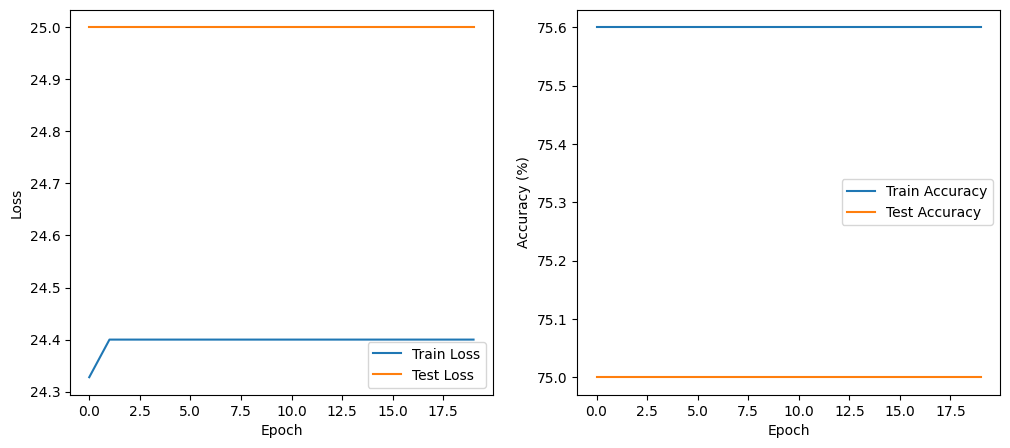

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [8]:
torch.save(model.state_dict(), 'stegano_cnn.pth')
print("Modell gespeichert als 'stegano_cnn.pth'")

Modell gespeichert als 'stegano_cnn.pth'


# 8. DEBUGGING


In [17]:
for images, labels in train_loader1:
        #für cuda
        images, labels = images.to(device), labels.to(device)
# Example: Visualize predictions and labels
outputs = model(images).squeeze().detach().cpu().numpy()
predictions = (outputs > 0.5).astype(int)
print(f"Predictions: {predictions}")
print(f"Labels: {labels.cpu().numpy()}")

Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels: [0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1]


In [18]:
from collections import Counter
print(Counter(train_dataset.labels))  # Adjust `train_dataset.labels` to match your data structure

Counter({1: 12000, 0: 4000})
